In [57]:
from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import concordance_index_censored, concordance_index_ipcw
from sklearn.model_selection import train_test_split
from sksurv.util import Surv
import pandas as pd
import numpy as np

In [58]:
dataset = pd.read_csv("data_ready_45.csv")

In [59]:
dataset = dataset.drop(columns=['PERIP_VASC', 'AMIS', 'BMIS', 'DRMIS', 'NON_HRT_DON', 'BLOOD_INF_CONF_DON', 'OTHER_INF_CONF_DON', 'PT_T3_DON', 'URINE_INF_CONF_DON', 'HIST_HYPERTENS_DON', 'HIST_CANCER_DON', 'HEPARIN_DON', 'HGT_CM_DON_CALC', 'WGT_KG_DON_CALC', 'MULTIORG', 'DAYSWAIT_CHRON_PA', 'CMV_IGM', 'HBV_CORE', 'HBV_SUR_ANTIGEN', 'HCV_SEROSTATUS', 'TX_TYPE_PTA', 'TX_TYPE_PWK', 'MALIG', 'HGT_CM_CALC', 'WGT_KG_CALC', 'CARDARREST_NEURO', 'RESUSCIT_DUR'])

In [60]:
dataset.to_csv("small_dataset.csv", index=False)

In [61]:
vars = ['ORGAN_isKP', 'MED_COND_TRR_is3', 'AGE', 'CREAT_TRR', 'BMI_CALC', 'NPPAN', 'CLIN_INFECT_DON', 'ABO_MAT', 'SGPT_DON', 'CMV_IGG', "GRF_STAT_PA", "time_frame"]


In [62]:
dataset = dataset[vars]

In [63]:
data_cox = dataset.copy()
data_kp = dataset.copy()


In [64]:
# dataset = dataset[dataset['time_frame'] != 30]
# dataset = dataset[dataset['time_frame'] != 365]
# dataset = dataset[dataset['time_frame'] != 365*5]
# dataset = dataset[dataset['time_frame'] != 365*10]

In [65]:
y = Surv.from_dataframe('GRF_STAT_PA', 'time_frame', dataset)
dataset = dataset.drop(columns=['GRF_STAT_PA', 'time_frame'])
X = dataset

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y["GRF_STAT_PA"], random_state=42)

## RSF

In [67]:
rsf = RandomSurvivalForest(n_estimators=250, max_depth=5, max_leaf_nodes=15, verbose=1, n_jobs=-1, random_state=42)

In [ ]:
rsf.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.8s


In [53]:
print(rsf.score(X_train, y_train))
print(rsf.score(X_test, y_test))

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   29.2s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:  2.3min
[Parallel(n_jobs=8)]: Done 250 out of 250 | elapsed:  3.0min finished


0.6847054720629432


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    5.3s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   25.5s


0.6756038141436901


[Parallel(n_jobs=8)]: Done 250 out of 250 | elapsed:   34.9s finished


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    3.2s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   16.3s
[Parallel(n_jobs=8)]: Done 250 out of 250 | elapsed:   21.9s finished


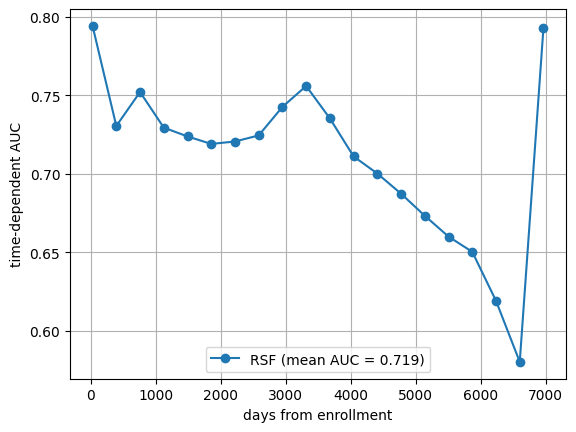

In [54]:
import matplotlib.pyplot as plt
from sksurv.metrics import cumulative_dynamic_auc



y_train = pd.DataFrame(y_train, columns=["GRF_STAT_PA", "time_frame"])
y_test = pd.DataFrame(y_test, columns=["GRF_STAT_PA", "time_frame"])

y_train["GRF_STAT_PA"] = y_train["GRF_STAT_PA"].astype("bool")
y_test["GRF_STAT_PA"] = y_test["GRF_STAT_PA"].astype("bool")

# Prepare survival objects for train and test data
y_test_surv = Surv.from_dataframe("GRF_STAT_PA", "time_frame", data=y_test)
y_train_surv = Surv.from_dataframe("GRF_STAT_PA", "time_frame", data=y_train)


times = np.arange(30, 365*20, 365)

rsf_scores = rsf.predict_cumulative_hazard_function(X_test, return_array=False)
rsf_surv = np.vstack([chf(times) for chf in rsf_scores])

rsf_auc, rsf_mean_auc = cumulative_dynamic_auc(y_train_surv, y_test_surv, rsf_surv, times)


plt.plot(times, rsf_auc, "o-", label=f"RSF (mean AUC = {rsf_mean_auc:.3f})")
plt.xlabel("days from enrollment")
plt.ylabel("time-dependent AUC")
plt.legend(loc="lower center")
plt.grid(True)

In [10]:
from sksurv.ensemble import RandomSurvivalForest
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
import pandas as pd

# Assume X, y contain your features and survival data
# Replace these with your actual data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define and fit the RSF model
rsf = RandomSurvivalForest(n_estimators=250, max_depth=5, max_leaf_nodes=10, verbose=1, n_jobs=-1, random_state=42)
rsf.fit(X_train, y_train)

# Step 1: Calculate permutation importance
perm_importance = permutation_importance(rsf, X_test, y_test, n_repeats=1, random_state=42, n_jobs=-1)

# Organize permutation importance results into a dataframe
perm_importance_df = pd.DataFrame({
    'feature': X.columns,  # Assuming X is a DataFrame; adjust if X is a numpy array
    'importance': perm_importance.importances_mean,
    'std': perm_importance.importances_std
})

# Sort permutation importance by importance score
perm_importance_df = perm_importance_df.sort_values(by='importance', ascending=False)

# Step 2: Compute Relative Variable Importance (RVI) using the fitted RSF model
rvi = rsf.variable_importance_

# Convert RVI to a dataframe
rvi_df = pd.DataFrame({
    'feature': X.columns,  # Assuming X is a DataFrame
    'RVI': rvi
})

# Sort by RVI values
rvi_df = rvi_df.sort_values(by='RVI', ascending=False)

# Step 3: Calculate cumulative RVI and sort by it
rvi_df['cumulative_RVI'] = rvi_df['RVI'].cumsum()

# Sort by cumulative RVI
rvi_df = rvi_df.sort_values(by='cumulative_RVI', ascending=False)

# Display the final sorted dataframe with permutation importance and cumulative RVI
final_df = pd.merge(rvi_df, perm_importance_df, on='feature', how='inner')
final_df = final_df.sort_values(by='cumulative_RVI', ascending=False)

# Output the final dataframe
print(final_df)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   22.0s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   30.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    5.7s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   26.6s
[Parallel(n_jobs=8)]: Done 250 out of 250 | elapsed:   35.6s finished


AttributeError: 'RandomSurvivalForest' object has no attribute 'variable_importance_'

In [27]:
my_imps = pd.DataFrame({
    "vars": X.columns,  # Directly use X.columns (no need for pd.DataFrame here)
    "imps": perm_importance["importances_mean"]  # Use the mean importance values for each feature
})

# Display the resulting DataFrame



# Step 1: Calculate the sum of all importances
total_importance = my_imps['imps'].sum()

# Step 2: Calculate RVI by dividing each importance by the total importance
my_imps['RVI'] = my_imps['imps'] / total_importance
my_imps = my_imps.sort_values(by='imps', ascending=False)
my_imps['Cumulative_RVI'] = my_imps['RVI'].cumsum()

my_imps.head(10)

,vars,imps,RVI,Cumulative_RVI
39,ORGAN_isKP,0.050380,0.446099,0.446099
43,MED_COND_TRR_is3,0.025222,0.223337,0.669436
27,AGE,0.017654,0.156317,0.825752
2,CREAT_TRR,0.010175,0.090096,0.915848
44,BMI_CALC,0.003928,0.034782,0.950630
5,NPPAN,0.001907,0.016886,0.967516
21,CLIN_INFECT_DON,0.000921,0.008155,0.975671
26,ABO_MAT,0.000484,0.004286,0.979957
18,SGPT_DON,0.000481,0.004263,0.984220
40,CMV_IGG,0.000440,0.003900,0.988119


In [ ]:
import optuna
import numpy as np
from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import cumulative_dynamic_auc
from sklearn.model_selection import train_test_split
from sksurv.util import Surv



# Create structured array for survival data (y_train and y_test)
y_train = Surv.from_arrays(event=y_train["GRF_STAT_PA_didFail"], time=y_train["time_frame"])
y_test = Surv.from_arrays(event=y_test["GRF_STAT_PA_didFail"], time=y_test["time_frame"])

# Define the objective function for Optuna optimization
def objective(trial):
    # Suggest hyperparameters for RSF
    n_estimators = trial.suggest_int('n_estimators', 100, 200)
    max_depth = trial.suggest_int('max_depth', 5, 15)
    min_samples_split = trial.suggest_int('min_samples_split', 5, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 5, 15)
    
    # Define the RSF model with suggested hyperparameters
    rsf = RandomSurvivalForest(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42,
        n_jobs=4
    )
    
    # Fit the model on the training set
    rsf.fit(X_train, y_train)

    preds = rsf.predict(X_test)
    # Predict risk scores on the validation set
    c_index = concordance_index_ipcw(y_train, y_test, preds)

    
    
    # Use mean AUC as the evaluation metric
    if trial.should_prune():
        raise optuna.TrialPruned()

    # Return the negative mean AUC (since Optuna minimizes by default, we negate it to maximize AUC)
    return c_index[0]

# Set up a pruner to stop unpromising trials early
pruner = optuna.pruners.MedianPruner()

# Create an Optuna study
study = optuna.create_study(direction='maximize', pruner=pruner)  

# Optimize the study
study.optimize(objective, n_trials=100)  # Run 50 trials

# Print the best hyperparameters
print("Best Hyperparameters:", study.best_params)

# Print the best score
print("Best CI:", study.best_value)  # Revert back to positive AUC


## Optuna 2

In [ ]:
import optuna
import numpy as np
from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import cumulative_dynamic_auc, concordance_index_ipcw
from sklearn.model_selection import train_test_split
from sksurv.util import Surv

# Create structured array for survival data (y_train and y_test)
y_train = Surv.from_arrays(event=y_train["GRF_STAT_PA"], time=y_train["time_frame"])
y_test = Surv.from_arrays(event=y_test["GRF_STAT_PA"], time=y_test["time_frame"])

# Define the objective function for Optuna optimization
def objective(trial):
    # Suggest hyperparameters for RSF
    n_estimators = trial.suggest_int('n_estimators', 100, 300)
    max_depth = trial.suggest_int('max_depth', 5, 20)

    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])

    max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 10, 100)
    
    # Define the RSF model with suggested hyperparameters
    rsf = RandomSurvivalForest(
        n_estimators=n_estimators,
        max_depth=max_depth,
        max_features=max_features,
        max_leaf_nodes=max_leaf_nodes,
        random_state=42,
        n_jobs=7
    )
    
    # Fit the model on the training set
    rsf.fit(X_train, y_train)

    # Predict risk scores on the test set
    

    # Calculate concordance index
    c_index = rsf.score(X_test, y_test)

    # Use pruning based on the median of previous trials
    if trial.should_prune():
        raise optuna.TrialPruned()

    # Return the concordance index for maximization
    return c_index[0]

# Set up a pruner to stop unpromising trials early
pruner = optuna.pruners.SuccessiveHalvingPruner(min_resource=1, reduction_factor=4)

# Create an Optuna study
study = optuna.create_study(direction='maximize', pruner=pruner)

# Optimize the study
study.optimize(objective, n_trials=50)  # Run 100 trials with parallel processing

# Print the best hyperparameters
print("Best Hyperparameters:", study.best_params)


## rsfOOST

In [ ]:
from sksurv.ensemble import GradientBoostingSurvivalAnalysis

gbs = GradientBoostingSurvivalAnalysis(n_estimators=100, verbose=1)
gbs.fit(X_train, y_train)


In [ ]:
import matplotlib.pyplot as plt
from sksurv.metrics import cumulative_dynamic_auc



y_train = pd.DataFrame(y_train, columns=["GRF_STAT_PA", "time_frame"])
y_test = pd.DataFrame(y_test, columns=["GRF_STAT_PA", "time_frame"])

y_train["GRF_STAT_PA"] = y_train["GRF_STAT_PA"].astype("bool")
y_test["GRF_STAT_PA"] = y_test["GRF_STAT_PA"].astype("bool")

# Prepare survival objects for train and test data
y_test_surv = Surv.from_dataframe("GRF_STAT_PA", "time_frame", data=y_test)
y_train_surv = Surv.from_dataframe("GRF_STAT_PA", "time_frame", data=y_train)


times = np.arange(30, 365*20, 365)

rsf_scores = gbs.predict_cumulative_hazard_function(X_test, return_array=False)
rsf_surv = np.vstack([chf(times) for chf in rsf_scores])

rsf_auc, rsf_mean_auc = cumulative_dynamic_auc(y_train_surv, y_test_surv, rsf_surv, times)


plt.plot(times, rsf_auc, "o-", label=f"RSF (mean AUC = {rsf_mean_auc:.3f})")
plt.xlabel("days from enrollment")
plt.ylabel("time-dependent AUC")
plt.legend(loc="lower center")
plt.grid(True)

In [45]:
import numpy as np
import pandas as pd
from sksurv.metrics import concordance_index_censored
from sklearn.utils import shuffle

# Define a custom permutation importance function
def permutation_importance_survival(model, X, y, n_repeats=5, random_state=42):
    rng = np.random.RandomState(random_state)
    
    # Compute baseline score (C-index) on original data
    y_time, y_event = y['time_frame'], y['GRF_STAT_PA_didFail']
    baseline_cindex = concordance_index_censored(y_event, y_time, model.predict(X))[0]
    
    feature_importances = {}
    
    # Iterate over each feature in the dataset
    for col in X.columns:
        scores = []
        
        # Shuffle the feature n_repeats times and compute C-index
        for _ in range(n_repeats):
            X_permuted = X.copy()
            X_permuted[col] = shuffle(X[col], random_state=rng)
            permuted_cindex = concordance_index_censored(y_event, y_time, model.predict(X_permuted))[0]
            scores.append(permuted_cindex)
        
        # The importance score is the reduction in C-index after shuffling the feature
        feature_importances[col] = baseline_cindex - np.mean(scores)
    
    # Convert the results to a DataFrame for easier analysis
    importance_df = pd.DataFrame({
        "importances_mean": list(feature_importances.values()),
        "importances_std": np.std([list(feature_importances.values()) for _ in range(n_repeats)], axis=0),
    }, index=X.columns).sort_values(by="importances_mean", ascending=False)
    
    return importance_df

# Assuming you already have the model `rsf` trained and X_test, y_test are defined
# Example usage:
importances = permutation_importance_survival(rsf, X_test, y_test, n_repeats=5)
print(importances)


In [ ]:
risk_scores_test = rsf.predict(X_test)


In [ ]:

c_index = concordance_index_censored(y_test['GRF_STAT_PA_didFail'], y_test['time_frame'], risk_scores_test)
print(f"Test Concordance Index: {c_index}")

In [9]:
import matplotlib.pyplot as plt
from sksurv.nonparametric import kaplan_meier_estimator

# Assume y_train contains the structured array with 'event' and 'duration'
# We calculate the censoring survival curve, so we use ~y_train['event']
time, prob_censoring = kaplan_meier_estimator(~y_train['GRF_STAT_PA_didFail'], y_train['time_frame'])

# Plot the Kaplan-Meier curve for censoring
plt.step(time, prob_censoring, where="post")
plt.xlabel("Time")
plt.ylabel("Probability of Not Being Censored")
plt.title("Kaplan-Meier Curve for Censoring Survival Function")
plt.grid(True)
plt.show()


In [10]:
from sksurv.nonparametric import kaplan_meier_estimator
import numpy as np

# Assume y_train contains the structured array with 'event' and 'duration'
time, prob_censoring = kaplan_meier_estimator(~y_train['GRF_STAT_PA_didFail'], y_train['time_frame'])

# Find the maximum time point where the censoring survival function is greater than zero
valid_times = time[prob_censoring > 0]

# The last valid time point
max_valid_time = valid_times[-1] -1
print(f"Maximum valid time point where censoring is > 0: {max_valid_time}")


In [ ]:
import pandas as pd
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from sklearn.model_selection import train_test_split

# Assuming 'df' is your full dataset containing 'duration', 'event_occurred', and covariates

# Split the dataset into training and test sets
df_train, df_test = train_test_split(data_cox, test_size=0.2, random_state=42)

# Fit the Cox Proportional Hazards model on the training data
cox_model = CoxPHFitter(penalizer=0.1).fit(df_train, duration_col='time_frame', event_col='GRF_STAT_PA_didFail')

# Print the summary of the model
# cox_model.print_summary()
hazard_ratios = cox_model.hazard_ratios_

# Sort by absolute importance
sorted_hazard_ratios = hazard_ratios.sort_values(ascending=False)[:10]

print("Sorted Hazard Ratios:")
print(sorted_hazard_ratios)
# Get the C-Index on the training set
c_index_train = cox_model.concordance_index_
print(f"Concordance Index (Training Set): {c_index_train}")

# Predict risk scores for the test data
test_predictions = cox_model.predict_partial_hazard(df_test)

# Calculate the Concordance Index on the test data
c_index_test = concordance_index(df_test['time_frame'], -test_predictions, df_test['GRF_STAT_PA_didFail'])
print(f"Concordance Index (Test Set): {c_index_test}")


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix
corr_matrix = data_cox.corr()

# Plot the heatmap to visualize correlation
import pandas as pd

# Assume df is your DataFrame with 113 features
# Compute the correlation matrix

# Unstack the correlation matrix to get pairs of features and their correlation
corr_pairs = corr_matrix.unstack()

# Convert to DataFrame for easier filtering and sorting
corr_pairs = pd.DataFrame(corr_pairs, columns=['correlation']).reset_index()

# Rename columns for clarity
corr_pairs.columns = ['Feature1', 'Feature2', 'Correlation']

# Remove self-correlations (where Feature1 == Feature2)
corr_pairs = corr_pairs[corr_pairs['Feature1'] != corr_pairs['Feature2']]

# Sort by absolute correlation value (highest first)
corr_pairs['abs_corr'] = corr_pairs['Correlation'].abs()
sorted_corr_pairs = corr_pairs.sort_values(by='abs_corr', ascending=False)

# Drop the auxiliary abs_corr column
sorted_corr_pairs.drop(columns=['abs_corr'], inplace=True)

# Show the top correlations
print(sorted_corr_pairs.head(50))  # Change the number to show more or fewer correlations


In [ ]:
from sksurv.metrics import integrated_brier_score, brier_score
import numpy as np

# Define the time points at which to compute the Brier score
times = [30, 365, 365*5, 365*10]


# Predict survival functions for the test set
surv_funcs = rsf.predict_survival_function(X_test)

# Convert survival functions into probabilities at specific time points
preds = np.asarray([[fn(t) for t in times] for fn in surv_funcs])

# Compute Brier Score at specific times
brier_scores = brier_score(y_train, y_test, preds, times)
print(f"Brier Scores: {brier_scores}")

# Compute the Integrated Brier Score (IBS) over the specified time points
ibs = integrated_brier_score(y_train, y_test, preds, times)
print(f"Integrated Brier Score (IBS): {ibs}")


In [ ]:
surv_funcs = cox_model.predict_survival_function(df_test)

# Define the time points at which to compute the Brier score (30 days, 1 year, 5 years, 10 years)
times = [30, 365, 365 * 5, 365 * 10]

# Extract survival probabilities at the specific time points
preds = np.asarray([surv_funcs.loc[t].values for t in times]).T  # Transpose to match (n_samples, n_times)

# Convert the test data into the required format for sksurv
y_test = np.array([(status == 1, time) for status, time in zip(df_test['GRF_STAT_PA_didFail'], df_test['time_frame'])],
                  dtype=[('event', '?'), ('time', '<f8')])

y_train = np.array([(status == 1, time) for status, time in zip(df_train['GRF_STAT_PA_didFail'], df_train['time_frame'])],
                   dtype=[('event', '?'), ('time', '<f8')])

# Compute Brier Score at specific times
brier_scores = brier_score(y_train, y_test, preds, times)
print(f"Brier Scores: {brier_scores}")

# Compute the Integrated Brier Score (IBS) over the specified time points
ibs = integrated_brier_score(y_train, y_test, preds, times)
print(f"Integrated Brier Score (IBS): {ibs}")

In [ ]:
import numpy as np
from sksurv.metrics import cumulative_dynamic_auc
from sksurv.util import Surv
import pandas as pd
import matplotlib.pyplot as plt

# Convert y_train and y_test to DataFrames
y_train = pd.DataFrame(y_train, columns=["GRF_STAT_PA_didFail", "time_frame"])
y_test = pd.DataFrame(y_test, columns=["GRF_STAT_PA_didFail", "time_frame"])

y_train["GRF_STAT_PA_didFail"] = y_train["GRF_STAT_PA_didFail"].astype("bool")
y_test["GRF_STAT_PA_didFail"] = y_test["GRF_STAT_PA_didFail"].astype("bool")

# Prepare survival objects for train and test data
y_test_surv = Surv.from_dataframe("GRF_STAT_PA_didFail", "time_frame", data=y_test)
y_train_surv = Surv.from_dataframe("GRF_STAT_PA_didFail", "time_frame", data=y_train)

va_times = np.arange(30, 365*10, 365)
# Risk scores for the test set
rsf_chf_funcs = rsf.predict_cumulative_hazard_function(X_test, return_array=False)
rsf_risk_scores = np.vstack([chf(va_times) for chf in rsf_chf_funcs])

# Define time points where you want to compute AUC (in days)
times = np.percentile(y["time_frame"], np.linspace(5, 81, 15))

# Calculate time-dependent AUC

rsf_auc, rsf_mean_auc = cumulative_dynamic_auc(y_train_surv, y_test_surv, rsf_risk_scores, va_times)


plt.plot(va_times, rsf_auc, "o-", label=f"RSF (mean AUC = {rsf_mean_auc:.3f})")
plt.xlabel("days from enrollment")
plt.ylabel("time-dependent AUC")
plt.legend(loc="lower center")
plt.grid(True)
# rsf_auc, rsf_mean_auc = cumulative_dynamic_auc(va_y_train, va_y_test, rsf_risk_scores, va_times)


# # Print time-dependent AUC values
# print("AUC at different time points:", auc_values)

# # Calculate iAUC (mean AUC across time points using trapezoidal rule)
# iAUC = np.trapz(auc_values, time_points) / (time_points[-1] - time_points[0])

# print(f"Integrated AUC (iAUC): {iAUC}")
